In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from tqdm import tqdm
import torch
import numpy as np
import scanpy as sc
from omegaconf import OmegaConf
from cfgen.data.scrnaseq_loader import RNAseqLoader
from cfgen.models.base.encoder_model import EncoderModel
from scvi.distributions import NegativeBinomial
from torch.distributions import Bernoulli

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
dataset_conf = OmegaConf.load("../../configs/configs_encoder/dataset/pbmc10k_multimodal.yaml")
encoder_conf = OmegaConf.load("../../configs/configs_encoder/encoder/encoder_multimodal_joint.yaml")
encoder_conf["is_binarized"] = True

In [3]:
dataset = RNAseqLoader(dataset_conf.dataset_path,
                        layer_key=dataset_conf.layer_key,
                        covariate_keys=dataset_conf.covariate_keys,
                        subsample_frac=dataset_conf.subsample_frac, 
                        normalization_type=dataset_conf.normalization_type,
                        is_binarized=dataset_conf.is_binarized)

dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=64,
                                        shuffle=False,
                                        drop_last=False)

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [4]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}

encoder_model = EncoderModel(in_dim=gene_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_conf.theta_covariate, 
                              **encoder_conf)

In [5]:
state_dict_path = "../../project_folder/experiments/autoencoder_ckpt/train_autoencoder_pbmc10k_multimodal_joint/checkpoints/last.ckpt"
encoder_model.load_state_dict(torch.load(state_dict_path, weights_only=False)["state_dict"])

<All keys matched successfully>

In [53]:
X_merged_atac = []
X_merged_rna = []
labels = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        size_factor = {"rna": batch["X"]["rna"].sum(1).unsqueeze(1)}
        z = encoder_model.encode(batch)
        params_hat = encoder_model.decode(z, size_factor)
        X_hat_rna = NegativeBinomial(mu=params_hat["rna"], theta=torch.exp(encoder_model.theta)).sample()
        X_hat_atac = Bernoulli(probs=params_hat["atac"]).sample()

        X_merged_rna.append(batch["X"]["rna"].numpy())
        X_merged_atac.append(batch["X"]["atac"].numpy())
        X_merged_rna.append(X_hat_rna.numpy())
        X_merged_atac.append(X_hat_atac.numpy())
        
        labels.extend(["Real" for _ in range(len(batch["X"]["rna"]))])
        labels.extend(["Generated" for _ in range(len(X_hat_rna))])

100%|██████████| 125/125 [00:32<00:00,  3.84it/s]


In [54]:
X_merged_rna = np.concatenate(X_merged_rna)
X_merged_atac = np.concatenate(X_merged_atac)

In [55]:
adata_rna = sc.AnnData(X=X_merged_rna, 
                   obs={"dataset_type": labels})
adata_atac = sc.AnnData(X=X_merged_atac, 
                   obs={"dataset_type": labels})

In [56]:
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)
sc.tl.pca(adata_rna)
sc.pp.neighbors(adata_rna)
sc.tl.umap(adata_rna)

sc.tl.pca(adata_atac)
sc.pp.neighbors(adata_atac)
sc.tl.umap(adata_atac)

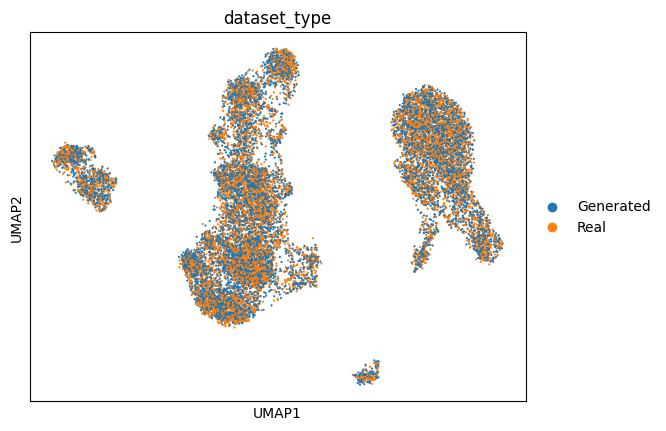

In [57]:
sc.pl.umap(adata_rna, color="dataset_type", s=10)

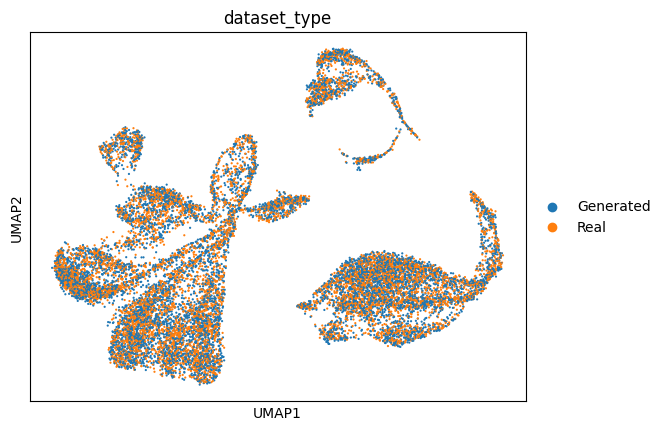

In [58]:
sc.pl.umap(adata_atac, color="dataset_type", s=10)